## Load data

### 환경변수

In [36]:
import sys
first = '/opt/conda/envs/python/lib/python3.6/site-packages'
end = [ path for path in sys.path if path != first ]
sys.path = [first] + end

import torch
print("torch path : ", torch.__file__)
print("cuda : ", torch.cuda.is_available())

torch path :  /opt/conda/envs/python/lib/python3.6/site-packages/torch/__init__.py
cuda :  True


In [3]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

In [4]:
file_s = 'interest.csv'

In [5]:
df1 = pd.read_csv(file_s, index_col='date') 
df1 = df1.iloc[::-1] # 과거에서 현재로 정렬순서 변경

In [6]:
df1.head(3)

,trea3,trea5,trea10
date,,,
2000-10-20,7.95,8.13,8.61
2000-10-21,7.94,8.13,8.61
2000-10-23,7.93,8.11,8.48


In [7]:
print(df1.isnull().values.any()) # 데이터 내 null값 없음
df1.head()

False


,trea3,trea5,trea10
date,,,
2000-10-20,7.95,8.130,8.610
2000-10-21,7.94,8.130,8.610
2000-10-23,7.93,8.110,8.480
2000-10-24,7.93,8.125,8.455
2000-10-25,7.90,8.080,8.415


/opt/conda/envs/python/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='date'>

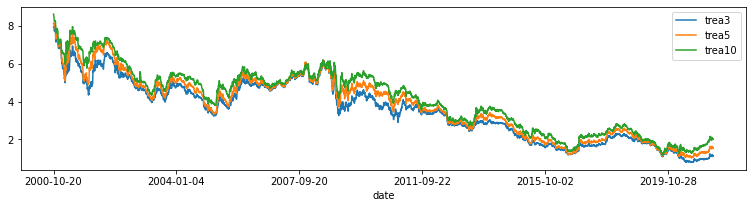

In [8]:
df1.plot(figsize=(13,3))

## Normalize data
금리의 절대적인 값은 시기에 따라 큰 차이를 나타낸다.  
과거 값으로 모델을 만들어도 현재에는 금리 레벨이 달라지므로 모델이 제대로 이해하기 어렵다.  
그러므로 시기별로 금리 값을 normalize 해 줄 필요가 있다.  
여기서는 n_window 값으로 설정하다. 기본 값으로 20 business days 를 설정한다.  
이렇게 하면 오늘의 금리 값은 오늘부터 (오늘을 포함한) 과거 20일 간의 평균값으로 나누어 준 값이 된다. 

In [9]:
n_window = 20
roll_df = df1.rolling(n_window).mean()
df_norm = df1/roll_df
df_norm.columns = ['trea3_norm', 'trea5_norm', 'trea10_norm']

In [10]:
df_norm

,trea3_norm,trea5_norm,trea10_norm
date,,,
2000-10-20,NaN,NaN,NaN
2000-10-21,NaN,NaN,NaN
2000-10-23,NaN,NaN,NaN
2000-10-24,NaN,NaN,NaN
2000-10-25,NaN,NaN,NaN
...,...,...,...
2021-04-09,1.013285,0.993002,0.983893
2021-04-12,0.989150,0.974592,0.973956
2021-04-13,0.988387,0.987404,0.989349


/opt/conda/envs/python/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='date'>

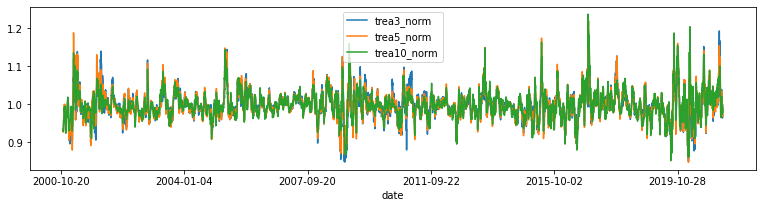

In [11]:
df_norm.plot(figsize=(13,3))

## 예측 타겟 값 설정
특정 기간 period size 동안의 퍼센트 차이 값을 타겟으로 설정  
몇 가지 기간에 대해 타겟 값을 구해보자  
(y0 - y_tgt)/y0,  
예) [5, 10, 20, 30] : 5일 후, 10일 후, 20일 후, 30일 후 예측  
사용하는 데이터는 tgt_data - (out_period -1) 시점까지 데이터 활용 가능

In [12]:
df_tgts = {}
periods = [5, 10, 20, 30]
for out_period in periods:
    df_tgt = df1[['trea3', 'trea5', 'trea10']].pct_change(periods=out_period)
    df_tgt.columns = ['trea3_diff', 'trea5_diff', 'trea10_diff']
    df_tgts[str(out_period)] = df_tgt

In [13]:
print(df1['trea3'][:10])
print(df1['trea3'].pct_change(periods=2)[:10])

date
2000-10-20    7.950
2000-10-21    7.940
2000-10-23    7.930
2000-10-24    7.930
2000-10-25    7.900
2000-10-26    7.865
2000-10-27    7.735
2000-10-28    7.735
2000-10-30    7.725
2000-10-31    7.765
Name: trea3, dtype: float64
date
2000-10-20         NaN
2000-10-21         NaN
2000-10-23   -0.002516
2000-10-24   -0.001259
2000-10-25   -0.003783
2000-10-26   -0.008197
2000-10-27   -0.020886
2000-10-28   -0.016529
2000-10-30   -0.001293
2000-10-31    0.003878
Name: trea3, dtype: float64


In [14]:
df_tgts['10'][-20:]

,trea3_diff,trea5_diff,trea10_diff
date,,,
2021-03-19,0.070291,0.124219,0.060150
2021-03-22,-0.017391,0.055336,0.009355
2021-03-23,-0.059836,-0.006231,0.000983
2021-03-24,-0.046809,-0.024204,-0.027027
2021-03-25,-0.068085,-0.013072,-0.028190
2021-03-26,-0.085366,-0.043614,-0.045131
2021-03-29,-0.086066,-0.061728,-0.085967
2021-03-30,-0.020426,0.000623,-0.009537
2021-03-31,-0.042481,-0.026220,-0.037886


In [15]:
df1.rolling(5).mean()

,trea3,trea5,trea10
date,,,
2000-10-20,NaN,NaN,NaN
2000-10-21,NaN,NaN,NaN
2000-10-23,NaN,NaN,NaN
2000-10-24,NaN,NaN,NaN
2000-10-25,7.9300,8.1150,8.5140
...,...,...,...
2021-04-09,1.1782,1.5924,2.0568
2021-04-12,1.1648,1.5728,2.0362
2021-04-13,1.1542,1.5628,2.0258


/opt/conda/envs/python/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='date'>

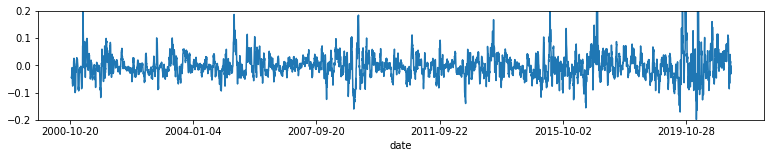

In [16]:
for key in df_tgts:
    pass
    #df_tgts[key]['trea10_diff'].plot(ylim=(-0.2, 0.2), figsize=(13,2))
df_tgts['10']['trea10_diff'].plot(ylim=(-0.2, 0.2), figsize=(13,2))

In [17]:
df2 = pd.concat([df1, df_norm, df_tgts['20']], axis=1)
df2b = df2.dropna()

In [18]:
df2b.head()

,trea3,trea5,trea10,trea3_norm,trea5_norm,trea10_norm,trea3_diff,trea5_diff,trea10_diff
date,,,,,,,,,
2000-11-13,7.135,7.310,7.605,0.927859,0.926783,0.929054,-0.102516,-0.100861,-0.116725
2000-11-14,7.155,7.305,7.605,0.935233,0.931018,0.934792,-0.098866,-0.101476,-0.116725
2000-11-15,7.245,7.390,7.680,0.951256,0.946193,0.948675,-0.086381,-0.088779,-0.094340
2000-11-16,7.290,7.440,7.705,0.961202,0.956790,0.956193,-0.080706,-0.084308,-0.088705
2000-11-17,7.275,7.425,7.690,0.963193,0.958900,0.958644,-0.079114,-0.081064,-0.086156


get historical data in format of LSTM : (time, input_size)

In [19]:
! pwd

/home/hubuc/model/time_series


## Make model

In [20]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import sys
lib_s = '/home/adminuser/public/libs/pytorch_examples/basic_networks'
sys.path.append(lib_s)
import generate_model as nets

In [21]:
class Index_data(Dataset):
    def __init__(self, in_data, tgt, n_window, out_period):
        """
        make it to each n_window old data gives next AMD price
        :param in_data: torch.tensor
        :param tgt: torch.tensor
        """
        self.in_data = in_data[:-1]
        self.tgt = tgt[n_window:] 
        self.n_window = n_window
        self.out_period = out_period
        
    def __getitem__(self, ii):
        """
        nets.Net assumes that data are given as (in_data, tgt)
        normalize by the first element
        """
        """
        normalize once again
        return (self.in_data[ii:ii+self.n_window]/self.in_data[ii], 
                self.tgt[ii+self.out_period-1])
        """
        return (self.in_data[ii:ii+self.n_window], 
                self.tgt[ii+self.out_period-1])
    
    def __len__(self):
        return len(self.tgt) - self.out_period + 1

In [22]:
import sys

In [23]:
sys.path

['/opt/conda/envs/python/lib/python3.6/site-packages',
 '',
 '/home/adminuser/.local/lib/python3.6/site-packages',
 '/opt/conda/envs/python/lib/python36.zip',
 '/opt/conda/envs/python/lib/python3.6',
 '/opt/conda/envs/python/lib/python3.6/lib-dynload',
 '/home/hubuc/.local/lib/python3.6/site-packages',
 '/opt/conda/envs/python/lib/python3.6/site-packages/IPython/extensions',
 '/home/hubuc/.ipython',
 '/home/adminuser/public/libs/pytorch_examples/basic_networks',
 '/home/adminuser/public/libs/pytorch_examples']

In [24]:
torch.__file__

'/opt/conda/envs/python/lib/python3.6/site-packages/torch/__init__.py'

In [25]:
torch.cuda.is_available()

True

In [26]:
df2b.head(2)

,trea3,trea5,trea10,trea3_norm,trea5_norm,trea10_norm,trea3_diff,trea5_diff,trea10_diff
date,,,,,,,,,
2000-11-13,7.135,7.310,7.605,0.927859,0.926783,0.929054,-0.102516,-0.100861,-0.116725
2000-11-14,7.155,7.305,7.605,0.935233,0.931018,0.934792,-0.098866,-0.101476,-0.116725


In [27]:
df_in = df2b[['trea3_norm', 'trea5_norm', 'trea10_norm']]  # 정규화 데이터 
df_in_np = df_in.to_numpy(np.single)
df_tgt_np = df2b['trea10_diff'].to_numpy(np.single) # 20일기준 수익률_국채10년 

tensor_in = torch.from_numpy(df_in_np)
tensor_tgt = torch.from_numpy(df_tgt_np)

In [28]:
tensor_in

tensor([[0.9279, 0.9268, 0.9291],
        [0.9352, 0.9310, 0.9348],
        [0.9513, 0.9462, 0.9487],
        ...,
        [0.9884, 0.9874, 0.9893],
        [0.9637, 0.9688, 0.9767],
        [0.9986, 0.9964, 0.9916]])

In [29]:
tensor_tgt

tensor([-0.1167, -0.1167, -0.0943,  ..., -0.0343, -0.0683, -0.0680])

In [30]:
# input size
n_window = 15
# prediction period
out_period = 10
n_history = len(df_in)
n_train = n_history//10*8
n_test = n_history - n_train
batch_size = 64
train_dset = Index_data(tensor_in[:n_train], tensor_tgt[:n_train], n_window, out_period)
test_dset = Index_data(tensor_in[n_train:], tensor_tgt[n_train:], n_window, out_period)
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

## Check testset
날짜 차이로 인해 테스트 셋 크기가 줄어드는 지 확인해 보자  
n_window : 15, out_period : 10 으로 인해 총 25개, 마지막날 결과를 보고 예측하므로 -1 --> 24개 차이

In [31]:
print(n_test)
len(test_dset)

1074


1050

In [32]:
class Predictor_rnn(nets.Net):
    def __init__(self, rnn=None, downnet=None,
                 loss=None, optimizer=None, device='cuda',
                 dim_input=100, dim_hidden=200):
        """
        net is consists of [embed, rnn, downnet]
        :param downnet: define downstream job
        """
        super(Predictor_rnn, self).__init__(loss=loss, device=device)
        
        if rnn is None:
            self.rnn = nn.LSTM(input_size=dim_input, 
                               hidden_size=dim_hidden, 
                               num_layers= 2,
                               batch_first=True,
                               bidirectional=False)
        else:
            self.rnn = rnn
            
        if downnet is None:
            self.downnet = nets.get_MLP([dim_hidden, dim_hidden*2, 1], 
                                        dropout=0.5, end=True)
        else:
            self.downnet = downnet
        
        self.init_weights()
        self.rnn = self.rnn.to(device)
        self.downnet = self.downnet.to(device)
        
        parms = list(self.rnn.parameters())
        parms += list(self.downnet.parameters())
        self.optimizer = optimizer(parms)
        
    def set_train(self):
        self.rnn.train()
        self.downnet.train()
        
    def set_eval(self):
        self.rnn.eval()
        self.downnet.eval()
    
    def init_weights(self):
        for ii, layer in enumerate(self.downnet):
            if 'Linear' in str(layer):
                torch.nn.init.xavier_uniform_(self.downnet[ii].weight)

    def forward(self, x):
        #print(x.size())
        #print(self.rnn(x))
        out, hidden = self.rnn(x)
        #print(out[:,-1].size())
        out = self.downnet(out[:,-1]) # choose last output
        return out.view(-1)

    def run_eval(self, data):
        self.set_eval()
        loss = 0
        outs = None
        tgts = None
        with torch.no_grad():
            for i_batch, data_batch in enumerate(data):
                data_in, tgt = data_batch
                data_in = data_in.to(self.device)
                tgt = tgt.to(self.device)
                out = self.forward(data_in)
                #print('loss', loss, self.loss)
                loss += self.loss(out, tgt).cpu().numpy()
                out = out.cpu().numpy()
                #print('loss===', loss)
                tgt = tgt.cpu().numpy()
                if outs is None:
                    outs = out
                    tgts = tgt
                else:
                    outs = np.concatenate((outs, out), axis=0)
                    tgts = np.concatenate((tgts, tgt), axis=0)
        loss /= 1.0*(i_batch+1)
        print('evaluate', 'loss', loss, 'accuracy : define function')
        return outs, tgts, loss

    """
    def run_batch(self, i_batch, data):
        self.optimizer.zero_grad()
        #print(data)
        data_in, tgt = data
        
        data_in = data_in.to(self.device)
        tgt = tgt.to(self.device)
        out = self.forward(data_in)
        loss = self.loss(out, tgt)
        loss.backward()
        self.optimizer.step()
        return loss.detach().cpu().item()
    """
    # If you customize learning, fix run_batch, run_train, run_eval
    #def run_batch(self, i_batch, data):
    #    pass

In [33]:
dim_input = df_in_np.shape[-1]
dim_hidden = 500
loss = nn.MSELoss() # which combines logsoftmax and nll loss
optimizer = optim.Adam
device = torch.device("cuda:0")

predictor = Predictor_rnn(loss=loss, optimizer=optimizer, 
                          device=device, dim_input=dim_input, 
                          dim_hidden=dim_hidden)

In [34]:
# normalize twice
predictor.run_train(n_epoch=200, data=train_loader)

epoch 0 loss 0.005976499513542252
eval_train evaluate loss 0.0037722851935106873 accuracy : define function
epoch 1 loss 0.003915321335557904
eval_train evaluate loss 0.003344784984226102 accuracy : define function
epoch 2 loss 0.0037024289703191217
eval_train evaluate loss 0.0033020710576075448 accuracy : define function
epoch 3 loss 0.00307968514102664
eval_train evaluate loss 0.0024139651187709463 accuracy : define function
epoch 4 loss 0.0026118832556947845
eval_train evaluate loss 0.002843620714300604 accuracy : define function
epoch 5 loss 0.002451304101329575
eval_train evaluate loss 0.002128905265717142 accuracy : define function
epoch 6 loss 0.002416891468091131
eval_train evaluate loss 0.0030327711772145842 accuracy : define function
epoch 7 loss 0.002297176916930658
eval_train evaluate loss 0.002081850260398837 accuracy : define function
epoch 8 loss 0.002343386706180259
eval_train evaluate loss 0.002447150138540388 accuracy : define function
epoch 9 loss 0.00229993978265061

In [35]:
# normalize once
predictor.run_train(n_epoch=200, data=train_loader)

epoch 0 loss 0.0017256702603980789
eval_train evaluate loss 0.0016392401259726107 accuracy : define function
epoch 1 loss 0.0017331365935518337
eval_train evaluate loss 0.0016108776778052214 accuracy : define function
epoch 2 loss 0.0017074538497323754
eval_train evaluate loss 0.00167459197804582 accuracy : define function
epoch 3 loss 0.0017616485719874834
eval_train evaluate loss 0.0016330161736583086 accuracy : define function
epoch 4 loss 0.0017395042571058468
eval_train evaluate loss 0.001607100218673473 accuracy : define function
epoch 5 loss 0.0017089712322314284
eval_train evaluate loss 0.0016829722192583244 accuracy : define function
epoch 6 loss 0.0017323739880543035
eval_train evaluate loss 0.001576606765451994 accuracy : define function
epoch 7 loss 0.0017231576155120536
eval_train evaluate loss 0.0015916747906342594 accuracy : define function
epoch 8 loss 0.0017760950340472384
eval_train evaluate loss 0.0017271075256988962 accuracy : define function
epoch 9 loss 0.00174092

In [37]:
tgts = None
preds = None
with torch.no_grad():
    for data_batch in test_loader:
        data_in, tgt = data_batch
        data_in = data_in.to(device)
        tgt = tgt.numpy()
        out = predictor.forward(data_in).cpu().numpy()
        if preds is None:
            preds = out
            tgts = tgt
        else:
            preds = np.concatenate((preds, out), axis=0)
            tgts = np.concatenate((tgts, tgt), axis=0)
preds = preds.reshape(-1)
tgts = tgts.reshape(-1)

## Check Accuracy
* normalize once : 상승, 하락으로만 정확도 평가, 77 % 
* normalize twice : 상승, 하락으로만 정확도 평가, 71 %  

In [38]:
# normalize once
sum1 = np.sum((preds > 0) & (tgts > 0))
sum2 = np.sum((preds < 0) & (tgts < 0))
print(sum1, np.sum(tgts>0))
print(sum2, np.sum(tgts<0))
print(len(preds), sum1+sum2, 1.0*(sum1+sum2)/len(preds))

388 523
418 521
1050 806 0.7676190476190476


In [39]:
# normalize twice
sum1 = np.sum((preds > 0) & (tgts > 0))
sum2 = np.sum((preds < 0) & (tgts < 0))
print(sum1, np.sum(tgts>0))
print(sum2, np.sum(tgts<0))
print(len(preds), sum1+sum2, 1.0*(sum1+sum2)/len(preds))

388 523
418 521
1050 806 0.7676190476190476


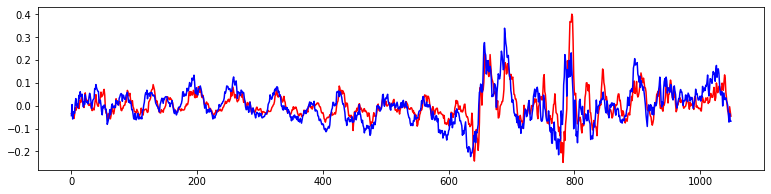

In [40]:
# normalize once
xs = range(len(preds))
fig1 = plt.figure(figsize=(13,3))
plt.plot(xs, preds, color='r')
plt.plot(xs, tgts, color='b')
plt.show()

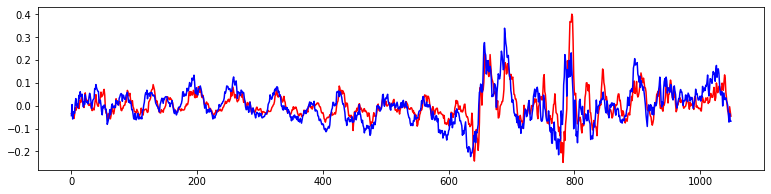

In [41]:
# normalize twice
xs = range(len(preds))
fig1 = plt.figure(figsize=(13,3))
plt.plot(xs, preds, color='r')
plt.plot(xs, tgts, color='b')
plt.show()

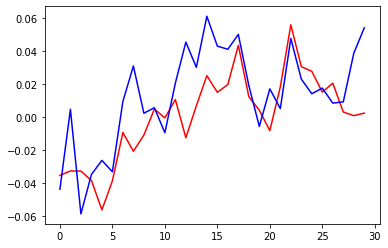

In [42]:
x_lim = 30
plt.plot(xs[:x_lim], preds[:x_lim], color='r')
plt.plot(xs[:x_lim], tgts[:x_lim], color='b')
plt.show()

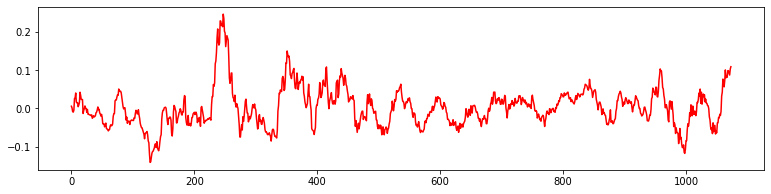

In [43]:
## CHECK data
ys_test = tensor_tgt[n_test:n_test*2]
xs_test = range(len(ys_test))
fig1 = plt.figure(figsize=(13,3))
plt.plot(xs_test, ys_test, color='r')
plt.show()

In [44]:
preds

array([-0.03526933, -0.03256932, -0.03266161, ..., -0.00460033,
       -0.02637905, -0.04596974], dtype=float32)

In [203]:
df1.index

Index(['2000-10-20', '2000-10-21', '2000-10-23', '2000-10-24', '2000-10-25',
       '2000-10-26', '2000-10-27', '2000-10-28', '2000-10-30', '2000-10-31',
       ...
       '2021-04-02', '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08',
       '2021-04-09', '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15'],
      dtype='object', name='date', length=5366)